In [1]:
import os, random, re, math
from tqdm import tqdm
from scipy.stats import iqr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## DeepFD benchmark (real faults)

In [2]:
subject_list = [
    "31880720",
    "41600519",
    "45442843",
    "48385830",
    "48594888",
    "50306988",
    "51181393",
    "56380303",
    "59325381"
]

algos = ["random", "hebo", "bohb"]
times = [10, 20, 50]

In [3]:
orig_accs_global = {}
metrics_global = {}
repaired_global = {}

In [4]:
def check_results_there(subject_paths):
    cnt = {}
    for path, pnum in subject_paths:
        if pnum not in cnt:
            cnt[pnum] = 0
        cnt[pnum] += 1
    print(cnt)

# Read results
HPO_subjects_path = "/home/hpo/results/DFD/"
subject_paths = []
for dir1 in os.listdir(HPO_subjects_path):
    dir1_path = os.path.join(HPO_subjects_path, dir1)
    if dir1.split("|")[1] in subject_list:
        subject_paths.append([dir1_path, dir1.split("|")[1]])
check_results_there(subject_paths)

# Read origin accuracies
HPO_DFD_orig_acc_path = "/home/hpo/data/DeepFD_orig_holdout_acc.txt"
orig_accs = {}
with open(HPO_DFD_orig_acc_path, "r") as f:
    for line in f:
        pnum, repair_acc = line.strip().split("|")
        if pnum not in orig_accs:
            orig_accs[pnum] = []
            orig_accs_global[pnum] = []

        orig_accs[pnum].append(float(repair_acc))
        orig_accs_global[pnum].append(float(repair_acc))

    for k, v in orig_accs.items():
        orig_accs[k] = [np.mean(v), np.std(v), iqr(v)]

# Read repaired accuracies
HPO_DFD_repair_path = "/home/hpo/data/DeepFD_repair_holdout_acc.txt"
repaired = {}

with open(HPO_DFD_repair_path, "r") as f:
    for line in f:
        pnum, repair_acc = line.strip().split("|")
        if pnum not in repaired:
            repaired[pnum] = []
            repaired_global[pnum] = []
            
        repaired[pnum].append(float(repair_acc))
        repaired_global[pnum].append(float(repair_acc))
    
    for k, v in repaired.items():
        repaired[k] = [np.mean(v), np.std(v), iqr(v)]
    


{'45442843': 90, '31880720': 90, '48594888': 90, '50306988': 90, '56380303': 90, '59325381': 90, '51181393': 90, '41600519': 90, '48385830': 90}


In [5]:
max_holdout_metrics = {}
for path, pnum in subject_paths:
    res = re.search(r"_([a-z]+)_iter_-1_time_([0-9]+)_repeat_([0-9]+)_top10_([0-1+])", path)
    algo, time, repeat, top10 = res.groups()
    key = f"{pnum}|{algo}|{time}|{top10}"

    if int(time) not in times or top10 == "0":
        continue
    
    df = pd.read_csv(path)
    df = df.iloc[1:]
    df = df.reset_index(drop=True)

    if "mean_loss" in list(df.columns):
        holdout_metric = df.iloc[df["mean_loss"].idxmin()]["holdout_loss"]
        if math.isnan(holdout_metric) or holdout_metric > orig_accs[pnum][0]:
            holdout_metric = orig_accs[pnum][0]
    else:
        holdout_metric = df.iloc[df["mean_accuracy"].idxmax()]["holdout_acc"]
        if math.isnan(holdout_metric) or holdout_metric < orig_accs[pnum][0]:
            holdout_metric = orig_accs[pnum][0]
    
    if key not in max_holdout_metrics:
        max_holdout_metrics[key] = []
        metrics_global[key] = []
        
    max_holdout_metrics[key].append(holdout_metric)
    metrics_global[key].append(holdout_metric)

metrics = {}
for k in sorted(max_holdout_metrics):
    pnum, algo, time, top10 = k.split("|")
    time = int(time)

    if pnum not in metrics:
        metrics[pnum] = {}
        for _time in times:
            metrics[pnum][_time] = {}
            for _algo in algos:
                metrics[pnum][_time][_algo] = []

    metrics[pnum][time][algo] = [np.mean(max_holdout_metrics[k]), np.std(max_holdout_metrics[k]), iqr(max_holdout_metrics[k])]

### Load and simluate AutoTrainer results

In [6]:
rng = random.Random(42)

def simulate(l, budget, mode="max"):    
    r, run_nums = [], [] 

    check = False
    for i in list(range(len(l))):
        if l.iloc[i]["TimeSpent"] < budget:
            check = True
            break

    if budget == -1 or not check:
        for _ in range(10):
            r.append("T/O")
        return r, None

    for _ in range(10):
        cnt = 0
        while True:
            _budget = 0
            _l = list(range(len(l)))
            rng.shuffle(_l)        
            bests = []
            for i in _l:
                _budget += l.iloc[i]["TimeSpent"]                
                # print(_budget)
                if _budget > budget:
                    break
                bests.append((l.iloc[i]["MaxAccuracy"], l.iloc[i]["RunNum"]))
            if len(bests) > 0:
                break

        if mode == "max":
            r.append(max(bests)[0])
            run_nums.append(max(bests)[1])
        elif mode == "min":
            r.append(min(bests)[0])
            run_nums.append(min(bests)[1])
        
    # print(budget, r)
    return r, run_nums

at_results_path = "/home/hpo/results/AutoTrainer/at_results.csv"
at_budget_path = "/home/hpo/results/AutoTrainer/at_deepfd_budget.csv"

df = pd.read_csv(at_results_path)
mutants_list = list(set(df["Mutant"]))

df_budget = pd.read_csv(at_budget_path)
at_budget = {10: {}, 20: {}, 50: {}}

for index, row in df_budget.iterrows():
    mutant = row["Mutant"]
    time = row["Number of Times Budget"]
    max_budget = row["Overall Budget (column B * column C)"]    
    max_budget_idx = len(eval(row["Indices to Consider"]))

    if max_budget_idx == 0:
        max_budget = -1

    at_budget[time][mutant] = max_budget


at_data = {10: {}, 20:{}, 50:{}}
runs_data = {}
for mutant in mutants_list:
    if "origin" not in mutant:
        continue
    
    # print(mutant)    
    mut_name = mutant[7:]
    runs_data[mut_name] = []

    _r, _run_nums = simulate(df[df["Mutant"] == mutant], at_budget[10][mutant])    
    at_data[10][mut_name] = metrics_global[f"{mut_name}|at|10|?"] = _r
    runs_data[mut_name].append((10, _run_nums))

    _r, _run_nums = simulate(df[df["Mutant"] == mutant], at_budget[20][mutant])    
    at_data[20][mut_name] = metrics_global[f"{mut_name}|at|20|?"] = _r
    runs_data[mut_name].append((20, _run_nums))

    _r, _run_nums = simulate(df[df["Mutant"] == mutant], at_budget[50][mutant])    
    at_data[50][mut_name] = metrics_global[f"{mut_name}|at|50|?"] = _r
    runs_data[mut_name].append((50, _run_nums))

# print(runs_data)
# with open("/home/hpo/results/AutoTrainer/deepfd_best_patches.csv", "w") as f:
#     for mutant, v in runs_data.items():
#         for time, _run_nums in v:            
#             f.write(f"{mutant}|{time}|{_run_nums}\n")
            



In [7]:
is_wilc = {}
with open("/home/hpo/data/wilcoxon_list.txt", "r") as f:
    for line in f:
        pnum, time, algo = line.strip().split(" ")
        time = int(time)
        is_wilc[(pnum, time, algo)] = True

# Without IQR
for j, pnum in enumerate(metrics.keys()):
    for time in [20]:
        
        # if time == times[0]:
        #     line = "\\multirow{3}{*}{" + f"D{j+1}" + "}" + f"& {time}" + " & "  
        # else:
        #     line = f" & {time}" + " & "  
        # if time == 20:
        # line = f"D{j+1} " + f"& {time}" + " & "  
        line = f"D{j+1} & "  


        # Buggy
        line += f"{orig_accs[pnum][0]:.2f} " + " & "     

        if pnum == "51181393":

            # HPO
            for _algo in algos:

                if (pnum, time, _algo) in is_wilc:
                    line += "\\textbf{" + f"{metrics[pnum][time][_algo][0]:.2f}" + "}" + f" & {metrics[pnum][time][_algo][1]:.2f} " + " & "
                else:
                    line += f"{metrics[pnum][time][_algo][0]:.2f} & {metrics[pnum][time][_algo][1]:.2f} " + " & "

                if _algo == "random":
                    # AutoTrainer
                    if pnum not in at_data[time] or at_data[time][pnum] is None:
                        line += " N/A & " * 2    
                    elif at_data[time][pnum][0] == "T/O":
                        line += " T/O & " * 2
                    else:
                        if (pnum, time, "at") in is_wilc:
                            line += "\\textbf{" + f"{np.mean(at_data[time][pnum]):.2f}" + "}" + f" & {np.std(at_data[time][pnum]):.2f}" + " & "     
                        else:
                            line += f"{np.mean(at_data[time][pnum]):.2f} & {np.std(at_data[time][pnum]):.2f}" + " & "  
        else:
            
            # HPO
            for _algo in algos:
                if (pnum, time, _algo) in is_wilc:
                    line += "\\textbf{" + f"{metrics[pnum][time][_algo][0]:.2f}" + "}" + f" & {metrics[pnum][time][_algo][1]:.2f} " + " & "
                else:
                    line += f"{metrics[pnum][time][_algo][0]:.2f} & {metrics[pnum][time][_algo][1]:.2f} " + " & "

                if _algo == "random":
                    # AutoTrainer
                    if pnum not in at_data[time] or at_data[time][pnum] is None:                        
                        line += " N/A & " * 2                                                     
                    elif at_data[time][pnum][0] == "T/O":
                        line += " T/O & " * 2
                    else:
                        if (pnum, time, "at") in is_wilc:
                            line += "\\textbf{" + f"{np.mean(at_data[time][pnum]):.2f}" + "}" + f" & {np.std(at_data[time][pnum]):.2f}" + " & "     
                        else:
                            line += f"{np.mean(at_data[time][pnum]):.2f} & {np.std(at_data[time][pnum]):.2f}" + " & "  
                
        # Repaired
        if pnum == "51181393":
            line += "\\textbf{" +  f"{repaired[pnum][0]:.2f}" + "}"  + " \\\\"

        else:
            line += "\\textbf{" +  f"{repaired[pnum][0]:.2f}" + "}" + " \\\\"

        print(line)
    

D1 & 0.52  & \textbf{1.00} & 0.00  &  T/O &  T/O & \textbf{0.76} & 0.24  & \textbf{0.95} & 0.14  & \textbf{1.00} \\
D2 & 0.53  & \textbf{0.67} & 0.00  & \textbf{0.68} & 0.00 & \textbf{0.67} & 0.00  & \textbf{0.67} & 0.01  & \textbf{0.71} \\
D3 & 0.61  & \textbf{1.00} & 0.01  & \textbf{0.93} & 0.00 & \textbf{1.00} & 0.00  & \textbf{1.00} & 0.00  & \textbf{1.00} \\
D4 & 0.10  & \textbf{0.95} & 0.02  & 0.10 & 0.00 & \textbf{0.94} & 0.03  & \textbf{0.93} & 0.06  & \textbf{0.94} \\
D5 & 0.66  & 0.66 & 0.00  &  N/A &  N/A & 0.66 & 0.00  & 0.66 & 0.00  & \textbf{0.75} \\
D6 & 0.45  & 0.60 & 0.20  &  T/O &  T/O & \textbf{0.85} & 0.21  & \textbf{0.65} & 0.23  & \textbf{1.00} \\
D7 & 6.71  & \textbf{0.91} & 1.73  &  N/A &  N/A & \textbf{2.48} & 2.85  & \textbf{0.49} & 1.02  & \textbf{0.13} \\
D8 & 0.22  & \textbf{0.57} & 0.03  & \textbf{0.54} & 0.00 & \textbf{0.57} & 0.02  & \textbf{0.57} & 0.02  & \textbf{0.33} \\
D9 & 0.10  & \textbf{0.13} & 0.03  & 0.10 & 0.00 & \textbf{0.13} & 0.03  & \textb

## DeepCrime mutants (artificial faults)

In [8]:
datasets = ["MNIST", "CIFAR", "REUTERS", "UNITY"]
algos = ["random", "hebo", "bohb"]
times = [10, 20, 50]
repair_files = ["mnist_conv.py", "cifar10_conv.py", "lenet.py", "reuters.py"]

In [9]:
def check_results_there(subject_paths):
    cnt = {}
    for path, pnum in subject_paths:
        res = re.search(r"_([a-z]+)_iter_-1_time_([0-9]+)_repeat_([0-9]+)_top10_([0-1+])", path)
        algo, time, repeat, top10 = res.groups()
        time = int(time)
        #
        if time not in times or algo not in algos or top10 != "1":
            continue
        #
        
        if pnum not in cnt:
            cnt[pnum] = 0
        cnt[pnum] += 1
    print(cnt)
    return cnt

subject_paths = []
for dataset in datasets:
    # Read results
    HPO_subjects_path = f"/home/hpo/results/{dataset}"
    
    _subject_paths = []
    for dir1 in os.listdir(HPO_subjects_path):
        dir1_path = os.path.join(HPO_subjects_path, dir1)
        _subject_paths.append([dir1_path, dir1.split("|")[1]])
    cnt_check = check_results_there(_subject_paths)
    for k, v in cnt_check.items():        
        if v in [45, 90]:
            for _sp, _sm in _subject_paths:
                if _sm == k:
                    subject_paths.append([_sp, k])

# Read origin and repaired accuracies
HPO_DC_orig_acc_path = "/home/hpo/data/DC_orig_holdout_acc.txt"
orig_accs, _repaired = {}, {}
with open(HPO_DC_orig_acc_path, "r") as f:
    for line in f:
        pnum, acc = line.strip().split("|")

        if pnum in repair_files:
            if pnum not in _repaired:
                _repaired[pnum] = []
                repaired_global[pnum] = []
            _repaired[pnum].append(float(acc))
            repaired_global[pnum].append(float(acc))
        else:
            if pnum not in orig_accs:
                orig_accs[pnum] = []
                orig_accs_global[pnum] = []

            orig_accs[pnum].append(float(acc))
            orig_accs_global[pnum].append(float(acc))
    
    for k, v in orig_accs.items():
        orig_accs[k] = [np.mean(v), np.std(v), iqr(v)]
    for k, v in _repaired.items():
        _repaired[k] = [np.mean(v), np.std(v), iqr(v)]
# print(repaired)


{'mnist_change_learning_rate_mutated0_MP_False_0.001.py': 90, 'mnist_remove_activation_function_mutated0_MP_7.py': 90, 'mnist_change_weights_initialisation_mutated0_MP_zeros_0.py': 90}
{'cifar10_change_activation_function_mutated0_MP_hard_sigmoid_2.py': 90, 'cifar10_change_epochs_mutated0_MP_1.py': 90, 'cifar10_change_weights_initialisation_mutated0_MP_ones_2.py': 90}
{'reuters_change_activation_function_mutated0_MP_softsign_2.py': 90, 'reuters_add_weights_regularisation_mutated0_MP_l1_0.py': 90, 'reuters_change_learning_rate_mutated0_MP_False_1.0.py': 90, 'reuters_change_weights_initialisation_mutated0_MP_ones_0.py': 90, 'reuters_change_optimisation_function_mutated0_MP_sgd.py': 90, 'reuters_remove_activation_function_mutated0_MP_2.py': 90, 'reuters_change_loss_function_mutated0_MP_hinge.py': 90}
{'lenet_change_weights_initialisation_mutated0_MP_ones_1_.py': 90, 'lenet_change_learning_rate_mutated0_MP_False_0.001.py': 90, 'lenet_change_loss_function_mutated0_MP_mean_squared_logarithmi

In [10]:
max_holdout_metrics = {}
for path, pnum in subject_paths:
    res = re.search(r"_([a-z]+)_iter_-1_time_([0-9]+)_repeat_([0-9]+)_top10_([0-1+])", path)
    algo, time, repeat, top10 = res.groups()
    key = f"{pnum}|{algo}|{time}|{top10}"
    
    if int(time) not in times or top10 == "0":
        continue
    
    df = pd.read_csv(path)
    df = df.iloc[1:]
    df = df.reset_index(drop=True)
    
    print(key, repeat)
    if "mean_loss" in list(df.columns):
        if pd.isnull(df["mean_loss"].idxmin()):
            holdout_metric = orig_accs[pnum][0]
        else:
            holdout_metric = df.iloc[df["mean_loss"].idxmin()]["holdout_loss"]
            if math.isnan(holdout_metric) or holdout_metric > orig_accs[pnum][0]:
                holdout_metric = orig_accs[pnum][0]
    else:
        if pd.isnull(df["mean_accuracy"].idxmax()):
            holdout_metric = orig_accs[pnum][0]
        else:
            holdout_metric = df.iloc[df["mean_accuracy"].idxmax()]["holdout_acc"]
            if math.isnan(holdout_metric) or holdout_metric < orig_accs[pnum][0]:
                holdout_metric = orig_accs[pnum][0]
    
    if key not in max_holdout_metrics:
        max_holdout_metrics[key] = []
        metrics_global[key] = []

    max_holdout_metrics[key].append(holdout_metric)
    metrics_global[key].append(holdout_metric)

metrics = {}
for k in sorted(max_holdout_metrics):
    pnum, algo, time, top10 = k.split("|")
    time = int(time)

    if pnum not in metrics:
        metrics[pnum] = {}
        for _time in times:
            metrics[pnum][_time] = {}
            for _algo in algos:
                metrics[pnum][_time][_algo] = []
    
    metrics[pnum][time][algo] = [np.mean(max_holdout_metrics[k]), np.std(max_holdout_metrics[k]), iqr(max_holdout_metrics[k])]
    # print(f"{pnum}, {algo}, {time}, {np.mean(max_holdout_metrics[k]):.3f}, {np.var(max_holdout_metrics[k]):.3f}")

mnist_change_learning_rate_mutated0_MP_False_0.001.py|hebo|50|1 6
mnist_change_learning_rate_mutated0_MP_False_0.001.py|bohb|10|1 9
mnist_change_learning_rate_mutated0_MP_False_0.001.py|bohb|20|1 7
mnist_change_learning_rate_mutated0_MP_False_0.001.py|random|10|1 4
mnist_change_learning_rate_mutated0_MP_False_0.001.py|random|10|1 1
mnist_change_learning_rate_mutated0_MP_False_0.001.py|hebo|20|1 0
mnist_change_learning_rate_mutated0_MP_False_0.001.py|hebo|50|1 1
mnist_change_learning_rate_mutated0_MP_False_0.001.py|bohb|10|1 4
mnist_change_learning_rate_mutated0_MP_False_0.001.py|random|20|1 9
mnist_change_learning_rate_mutated0_MP_False_0.001.py|bohb|20|1 9
mnist_change_learning_rate_mutated0_MP_False_0.001.py|hebo|20|1 9
mnist_change_learning_rate_mutated0_MP_False_0.001.py|random|10|1 8
mnist_change_learning_rate_mutated0_MP_False_0.001.py|bohb|50|1 0
mnist_change_learning_rate_mutated0_MP_False_0.001.py|hebo|10|1 3
mnist_change_learning_rate_mutated0_MP_False_0.001.py|random|50|1 9


In [11]:
rng = random.Random(42)

def simulate(l, budget, mode="max"):    
    r, run_nums = [], [] 

    check = False
    for i in list(range(len(l))):
        if l.iloc[i]["TimeSpent"] < budget:
            check = True
            break

    if budget == -1 or not check:
        for _ in range(10):
            r.append("T/O")
        return r, None

    for _ in range(10):
        cnt = 0
        while True:
            _budget = 0
            _l = list(range(len(l)))
            rng.shuffle(_l)        
            bests = []
            for i in _l:
                _budget += l.iloc[i]["TimeSpent"]                
                # print(_budget)
                if _budget > budget:
                    break
                bests.append((l.iloc[i]["MaxAccuracy"], l.iloc[i]["RunNum"]))
            if len(bests) > 0:
                break

        if mode == "max":
            r.append(max(bests)[0])
            run_nums.append(max(bests)[1])
        elif mode == "min":
            r.append(min(bests)[0])
            run_nums.append(min(bests)[1])
        
    # print(budget, r)
    return r, run_nums

at_results_path = "/home/hpo/results/AutoTrainer/at_results.csv"
at_budget_path = "/home/hpo/results/AutoTrainer/at_deepcrime_budget.csv"

df = pd.read_csv(at_results_path)
mutants_list = list(set(df["Mutant"]))

df_budget = pd.read_csv(at_budget_path)
at_budget = {10: {}, 20: {}, 50: {}}

for index, row in df_budget.iterrows():
    mutant = row["Mutant"]
    time = row["Number of Times Budget"]
    max_budget = row["Overall Budget (column B * column C)"]    
    max_budget_idx = len(eval(row["Indices to Consider"]))

    if "origin" in mutant:
        continue

    if max_budget_idx == 0:
        max_budget = -1
    at_budget[time][mutant] = max_budget


at_data = {10: {}, 20:{}, 50:{}}
runs_data = {}
for mutant in mutants_list:
    if "origin" in mutant:
        continue
    
    # print(mutant)    
    mut_name = mutant + ".py"
    runs_data[mut_name] = []

    _r, _run_nums = simulate(df[df["Mutant"] == mutant], at_budget[10][mutant])    
    at_data[10][mut_name] = metrics_global[f"{mut_name}|at|10|?"] = _r
    runs_data[mut_name].append((10, _run_nums))

    _r, _run_nums = simulate(df[df["Mutant"] == mutant], at_budget[20][mutant])    
    at_data[20][mut_name] = metrics_global[f"{mut_name}|at|20|?"] = _r
    runs_data[mut_name].append((20, _run_nums))

    _r, _run_nums = simulate(df[df["Mutant"] == mutant], at_budget[50][mutant])    
    at_data[50][mut_name] = metrics_global[f"{mut_name}|at|50|?"] = _r
    runs_data[mut_name].append((50, _run_nums))

# print(runs_data)
# with open("/home/hpo/results/AutoTrainer/deepcrime_best_patches.csv", "w") as f:
#     for mutant, v in runs_data.items():
#         for time, _run_nums in v:
#             f.write(f"{mutant}|{time}|{_run_nums}\n")



In [12]:
repaired = {
    "MNIST": _repaired["mnist_conv.py"],
    "CIFAR": _repaired["cifar10_conv.py"],
    "UNITY": _repaired["lenet.py"],
    "REUTERS": _repaired["reuters.py"]
}
fft = {"MNIST": 0,
       "CIFAR": 0,
       "UNITY": 0,
       "REUTERS": 0}
id_count = {"MNIST": 0,
       "CIFAR": 0,
       "UNITY": 0,
       "REUTERS": 0}
num_subjects = {
       "MNIST": 0,
       "CIFAR": 0,
       "UNITY": 0,
       "REUTERS": 0}

for j, pnum in enumerate(metrics.keys()):
    if "lenet" in pnum:
        dataset = "UNITY"
    elif "cifar10" in pnum:
        dataset = "CIFAR"
    elif "mnist" in pnum:
        dataset = "MNIST"
    elif "reuters" in pnum:
        dataset = "REUTERS"
    num_subjects[dataset] += 1


is_wilc = {}
with open("/home/hpo/data/wilcoxon_list.txt", "r") as f:
    for line in f:
        pnum, time, algo = line.strip().split(" ")
        time = int(time)
        is_wilc[(pnum, time, algo)] = True

# Without IQR
id_map = {}
for j, pnum in enumerate(metrics.keys()):    
    if "lenet" in pnum:
        dataset = "UNITY"
    elif "cifar10" in pnum:
        dataset = "CIFAR"
    elif "mnist" in pnum:
        dataset = "MNIST"
    elif "reuters" in pnum:
        dataset = "REUTERS"    
    # {\rotatebox[origin=c]{90}{Real}}
    id_count[dataset] += 1
    id_map[pnum] = f"{dataset[0]}{id_count[dataset]}"
    # for time in [10, 20, 50]:
    for time in [20]:
        if dataset == "UNITY":
            # if int(time) == 10:
            #     line = "\\multirow{3}{*}{" + f"{dataset[0]}{id_count[dataset]}" + "}" + f" & {time}" + " & "
            # else:
            #     line = f" & {time}" + " & "
            # if int(time) == 20:
            # line = f"{dataset[0]}{id_count[dataset]}" + f" & {time}" + " & "

            line = f"{dataset[0]}{id_count[dataset]}" + " & "

            # Buggy
            line += f"{orig_accs[pnum][0]:.3f}" + " & "
            
            for _algo in algos:
                if (pnum, time, _algo) in is_wilc:
                    line += "\\textbf{" +  f"{metrics[pnum][time][_algo][0]:.3f}" + "} " +f"& {metrics[pnum][time][_algo][1]:.3f} " + " & "
                else:
                    line += f"{metrics[pnum][time][_algo][0]:.3f} & {metrics[pnum][time][_algo][1]:.3f} " + " & "

                if _algo == "random":
                    # AutoTrainer
                    if pnum not in at_data[time] or at_data[time][pnum] is None:
                        line += " N/A & " * 2
                    elif at_data[time][pnum][0] == "T/O":
                        line += " T/O & " * 2
                    else:
                        if (pnum, time, "at") in is_wilc:
                            line += "\\textbf{" + f"{np.mean(at_data[time][pnum]):.2f}" + "}" + f" & {np.std(at_data[time][pnum]):.2f}" + " & "     
                        else:
                            line += f"{np.mean(at_data[time][pnum]):.2f} & {np.std(at_data[time][pnum]):.2f}" + " & "
                    
                
            line += "\\textbf{" + f"{repaired[dataset][0]:.3f}" + "} " + " \\\\"
        else:

            # line = f"{dataset[0]}{id_count[dataset]}" + f" & {time}" + " & "
            line = f"{dataset[0]}{id_count[dataset]}" + " & "            
            
            # Buggy
            line += f"{orig_accs[pnum][0]:.2f}" + " & "
            
            for _algo in algos:
                if (pnum, time, _algo) in is_wilc:
                    line += "\\textbf{" + f"{metrics[pnum][time][_algo][0]:.2f}" + "} " + f"& {metrics[pnum][time][_algo][1]:.2f} " + " & "
                else:
                    line += f"{metrics[pnum][time][_algo][0]:.2f} & {metrics[pnum][time][_algo][1]:.2f} " + " & "
                    
                if _algo == "random":
                    # AutoTrainer
                    if pnum not in at_data[time] or at_data[time][pnum] is None:
                        line += " N/A & " * 2
                    elif at_data[time][pnum][0] == "T/O":
                        line += " T/O & " * 2
                    else:
                        if (pnum, time, "at") in is_wilc:
                            line += "\\textbf{" + f"{np.mean(at_data[time][pnum]):.2f}" + "}" + f" & {np.std(at_data[time][pnum]):.2f}" + " & "     
                        else:
                            line += f"{np.mean(at_data[time][pnum]):.2f} & {np.std(at_data[time][pnum]):.2f}" + " & "
            
            
            line += "\\textbf{" + f"{repaired[dataset][0]:.2f}" + "} " + " \\\\"
            

        fft[dataset] += 1
        print(line)
# print(id_map)

C1 & 0.61 & 0.61 & 0.00  & \textbf{0.71} & 0.01 & 0.61 & 0.00  & 0.61 & 0.00  & \textbf{0.70}  \\
C2 & 0.52 & 0.52 & 0.00  &  N/A &  N/A & 0.52 & 0.00  & 0.52 & 0.00  & \textbf{0.70}  \\
C3 & 0.49 & 0.49 & 0.00  &  N/A &  N/A & 0.49 & 0.00  & 0.49 & 0.00  & \textbf{0.70}  \\
U1 & 0.184 & \textbf{0.152} & 0.051  &  N/A &  N/A & \textbf{0.184} & 0.000  & \textbf{0.184} & 0.000  & \textbf{0.044}  \\
U2 & 0.118 & \textbf{0.050} & 0.056  &  N/A &  N/A & \textbf{0.004} & 0.000  & 0.061 & 0.057  & \textbf{0.044}  \\
U3 & 0.121 & 0.057 & 0.055  &  N/A &  N/A & \textbf{0.028} & 0.047  & 0.084 & 0.052  & \textbf{0.044}  \\
U4 & 0.400 & 0.087 & 0.126  &  N/A &  N/A & \textbf{0.004} & 0.000  & \textbf{0.004} & 0.000  & \textbf{0.044}  \\
U5 & 0.071 & 0.071 & 0.000  &  N/A &  N/A & 0.071 & 0.000  & 0.071 & 0.000  & \textbf{0.044}  \\
U6 & 0.130 & 0.080 & 0.061  &  N/A &  N/A & 0.080 & 0.061  & \textbf{0.042} & 0.058  & \textbf{0.044}  \\
U7 & 0.098 & \textbf{0.023} & 0.037  &  N/A &  N/A & \textbf{

In [25]:
from pickle import FALSE
from scipy.stats import wilcoxon
import scipy.stats as ss
from bisect import bisect_left


def cohen_d(orig_accuracy_list, accuracy_list):
    nx = len(orig_accuracy_list)
    ny = len(accuracy_list)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*np.std(orig_accuracy_list, ddof=1) ** 2 + (ny-1)*np.std(accuracy_list, ddof=1) ** 2) / dof)
    if pooled_std == 0:
        return 2**32
    result = (np.mean(orig_accuracy_list) - np.mean(accuracy_list)) / pooled_std
    return result

def VD_A(treatment, control):
    """
    Computes Vargha and Delaney A index
    A. Vargha and H. D. Delaney.
    A critique and improvement of the CL common language
    effect size statistics of McGraw and Wong.
    Journal of Educational and Behavioral Statistics, 25(2):101-132, 2000
    The formula to compute A has been transformed to minimize accuracy errors
    See: http://mtorchiano.wordpress.com/2014/05/19/effect-size-of-r-precision/
    :param treatment: a numeric list
    :param control: another numeric list
    :returns the value estimate and the magnitude
    """
    m = len(treatment)
    n = len(control)

    if m != n:
        raise ValueError("Data d and f must have the same length")

    r = ss.rankdata(treatment + control)
    r1 = sum(r[0:m])

    # Compute the measure
    # A = (r1/m - (m+1)/2)/n # formula (14) in Vargha and Delaney, 2000
    A = (2 * r1 - m * (m + 1)) / (2 * n * m)  # equivalent formula to avoid accuracy errors

    levels = [0.147, 0.33, 0.474]  # effect sizes from Hess and Kromrey, 2004
    magnitude = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2

    magnitude = magnitude[bisect_left(levels, abs(scaled_A))]
    estimate = A

    return estimate, magnitude



pnum_time = {}
for k, v in metrics_global.items():
    pnum, algo, time, top10 = k.split("|")
    time = int(time)
    ###########################
    # if time != 50:
    #     continue
    ###########################

    if f"{pnum}|{time}" not in pnum_time:
        pnum_time[f"{pnum}|{time}"] = {}
    
    if v == None:
        pnum_time[f"{pnum}|{time}"][algo] = None
    elif v[0] == "T/O":                
        pnum_time[f"{pnum}|{time}"][algo] = "T/O"
    else:
        pnum_time[f"{pnum}|{time}"][algo] = [round(x, 2) for x in v]

    pnum_time[f"{pnum}|{time}"]["orig"] = orig_accs_global[pnum]
    
    fname = None
    if "lenet" in pnum:
        fname = "lenet.py"
    elif "cifar10" in pnum:
        fname = "cifar10_conv.py"
    elif "mnist" in pnum:
        fname = "mnist_conv.py"
    elif "reuters" in pnum:
        fname = "reuters.py"

    if fname is not None:
        pnum_time[f"{pnum}|{time}"]["repaired"] = repaired_global[fname]
    else:
        pnum_time[f"{pnum}|{time}"]["repaired"] = repaired_global[pnum]

wilcoxon_results = {
    "random": [0, 0],
    "hebo": [0, 0],
    "bohb": [0, 0],
    "at": [0, 0]
}
wilcoxon_time_results = {}
for time in [10, 20, 50]:
    wilcoxon_time_results[time] = {
        "random": [0, 0],
        "hebo": [0, 0],
        "bohb": [0, 0],
        "at": [0, 0]
    }

improvement_results = {}
for time in [10, 20, 50]:
    improvement_results[time] = {
        "random": [],
        "hebo": [],
        "bohb": [],
        "at": []
    }

effect_results = {
    "random": [0, 0],
    "hebo": [0, 0],
    "bohb": [0, 0],
    "at": [0, 0]
}
effect_time_results = {}
for time in [10, 20, 50]:
    effect_time_results[time] = {
        "random": [0, 0],
        "hebo": [0, 0],
        "bohb": [0, 0],
        "at": [0, 0]
    }

std_results = {
    "random": [],
    "hebo": [],
    "bohb": [],
    "at": []
}

AT_NA_LIST = ["mnist_change_learning_rate_mutated0_MP_False_0.001.py",
                    "cifar10_change_weights_initialisation_mutated0_MP_ones_2.py",
                    "cifar10_change_epochs_mutated0_MP_1.py",
                    "48594888"]

for k, v in pnum_time.items():
    pnum, time = k.split("|")
    time = int(time)
    
    if pnum in AT_NA_LIST: # because AT cannot find any symptom
        effect_results["at"][1] += 1   
        wilcoxon_results["at"][1] += 1
        wilcoxon_time_results[time]["at"][1] += 1
        effect_time_results[time]["at"][1] += 1
        improvement_results[time]["at"].append(0)         


    #######################
    # if pnum not in AT_NA_LIST and "at" not in v:        
    #     continue

    # check = False
    # for algo, _v in v.items():
    #     if _v is None or _v == "T/O":
    #         check = True
    # if check:        
    #     continue    
    #######################
    
    if "51181393" in k or "lenet" in k: # smaller is better
        for algo, _v in v.items():
            if algo in ["orig", "repaired"] or _v is None or _v == "T/O":
                continue
            
            a12 = VD_A(v["orig"], _v)
            improvement = (np.mean(v["orig"]) - np.mean(_v)) / (np.mean(v["orig"]) - np.mean(v["repaired"]))

            try:
                _, p_val = wilcoxon(v["orig"], _v)
            except ValueError as e:
                p_val = 1            
            if p_val < 0.05:
                if improvement > 0:
                    wilcoxon_results[algo][0] += 1
                    wilcoxon_time_results[time][algo][0] += 1
                    std_results[algo].append(np.std(_v))
                # if improvement > 0:
                #     print(f"{pnum} {time} {algo}")
                
            # print(f"{pnum} {time} {algo} {p_val:.3f}")

            wilcoxon_results[algo][1] += 1
            wilcoxon_time_results[time][algo][1] += 1
                   
            improvement_results[time][algo].append(improvement)
            

            
    else: # acc
        for algo, _v in v.items():

            if algo in ["orig", "repaired"] or _v is None or _v == "T/O":                
                continue

            a12 = VD_A(_v, v["orig"])
            improvement = (np.mean(_v) - np.mean(v["orig"])) / (np.mean(v["repaired"]) - np.mean(v["orig"]))

            try:
                _, p_val = wilcoxon(v["orig"], _v)
            except ValueError as e:
                p_val = 1            

            if p_val < 0.05:
                if improvement > 0:
                    wilcoxon_results[algo][0] += 1
                    wilcoxon_time_results[time][algo][0] += 1
                    std_results[algo].append(np.std(_v))
 
                # if improvement > 0:                    
                #     print(f"{pnum} {time} {algo}")
            # print(f"{pnum} {time} {algo} {p_val:.3f}")
            wilcoxon_results[algo][1] += 1
            wilcoxon_time_results[time][algo][1] += 1

            improvement_results[time][algo].append(improvement)
            if algo == "random" and improvement > 1.6:
                print(f"{pnum} {time} {algo} {improvement}")
            
    
# for time in [10, 20, 50]:
#     print(time)
#     for k, v in wilcoxon_time_results[time].items():    
#         print(k, v[0], v[1], f"{v[0] / v[1] * 100:.2f}")

# for k, v in wilcoxon_results.items():    
#     print(k, v[0], v[1], f"{v[0] / v[1] * 100:.2f}")

# for k, v in effect_results.items():    
#     print(k, v[0], v[1], f"{v[0] / v[1] * 100:.2f}")

# for k, v in std_results.items():    
#     print(k, f"{np.mean(v):.3f}")

# for _time, v in effect_time_results.items():    
#     for _algo, _v in v.items():
#         print(_time, _algo, _v)
    
# pnum_time




56380303 50 random 3.1696428571428577
56380303 20 random 3.133928571428572
56380303 10 random 2.9821428571428585


random, 20, 0.60, 0.55
at, 20, 0.46, 0.18
hebo, 20, 0.61, 0.55
bohb, 20, 0.57, 0.45


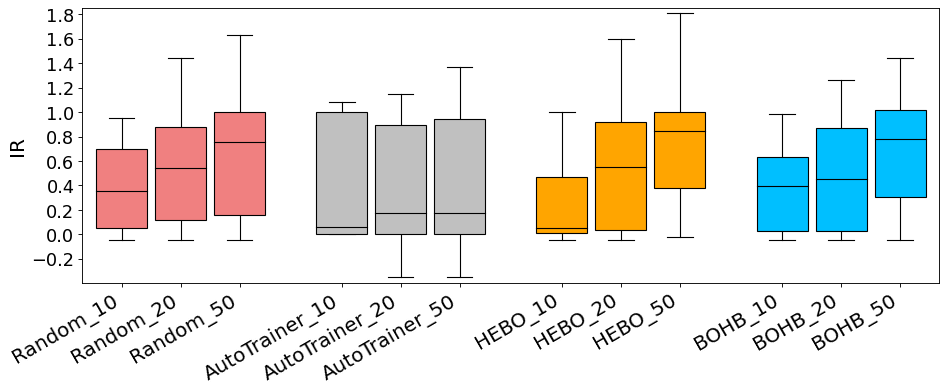

In [28]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 5), dpi=80)

x = 0
_w = 0.15
w = 0.11
width = 0.13

colors = {
    "random": "lightcoral",
    "hebo": "orange",
    "bohb": "deepskyblue",
    "at": "silver"
}

i = 0
for pnum in ["random", "at", "hebo", "bohb"]:    
    for j, time in enumerate([10, 20, 50]):
        bp = plt.boxplot([improvement_results[time][pnum]], positions=[x+_w*j], widths=width, notch=False, vert=True, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[pnum])
        for median in bp['medians']:
            median.set_color('black')
        if time == 20:
            print(f"{pnum}, {time}, {np.mean(improvement_results[time][pnum]):.2f}, {np.median(improvement_results[time][pnum]):.2f}")
        i += 1
        
    x += _w * 3 + w
        


xticks, xticks_labels = [], []
x = 0
for pnum in ["Random", "AutoTrainer", "HEBO", "BOHB"]:    
    for j, time in enumerate([10, 20, 50]):
        xticks.append(x + _w*j)
        xticks_labels.append(f"{pnum}_{time}")
    x += _w * 3 + w
plt.xticks(xticks, xticks_labels, rotation=30, ha="right", fontsize=18)

# plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.ylabel("IR", fontsize=18)
plt.xlim([xticks[0]-0.1, xticks[-1]+0.1])
plt.yticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8], fontsize=16)
plt.ylim([-0.4, 1.85])
plt.tight_layout()
plt.savefig(f'/home/hpo/figures/IR.pdf')
plt.show()
